In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import h5py
import os
import cv2 as cv
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter, MovieWriter

#### the H5 file are discribed in the README file of retina_lamina_demo (https://github.com/neurokernel/retina-lamina/tree/master/examples/retlam_demo)\
#### This is basically the rewriting of visualize_result.m 

In [2]:
# read ommatidia coordinates
elevr1 = h5py.File('retina_elev.h5', 'r')['array']
print(elevr1)
azim1 = h5py.File('retina_azim.h5', 'r')['array']
r1 = 1
y1 = -r1 * np.cos(elevr1) * np.sin(azim1)
x1 = -r1 * np.cos(elevr1) * np.cos(azim1)
z1 = r1 * np.sin(elevr1)
print(f'x1 is of shape{np.shape(x1)}') # x1, y1, z1 is of the same dimension of ommatidiates

# read screen coordinates(or grids more precisely)
elevr2 = h5py.File('grid_dima.h5', 'r')['array']
#print(np.shape(elevr2))
azim2 = h5py.File('grid_dimb.h5', 'r')['array']
r2 = 10
y2 = -r2 * np.cos(elevr2) * np.sin(azim2)
x2 = -r2 * np.cos(elevr2) * np.cos(azim2)
z2 = r2 * np.sin(elevr2)
print(f'x2 is of shape{np.shape(x2)}') # x2, y2, z2 is of the same size of input matrix, see below

<HDF5 dataset "array": shape (611,), type "<f8">
x1 is of shape(611,)
x2 is of shape(800, 50)


In [3]:
inputs = h5py.File('retina_input.h5', 'r')['photon']['data']
inputs = np.array(inputs)
print('the origin input has shape of {}'.format(np.shape(inputs)))

# inputs[frame, photoreceptor_index]
inputs = inputs[::10, :] # just drop off some frames to make life easier
outputs = h5py.File('retina_output0.h5', 'r')['V']['data']
outputs = np.array(outputs)
print('the origin output has shape of {}'.format(np.shape(outputs)))
outputs = outputs[::10, :]

R1_inputs = inputs[:, 0:-1:6] # get R1 inputs, since here there is no R7&R8
R1_outputs = outputs[:, 0:-1:6]
#print(R1_outputs)
#print(type(R1_inputs))
#print(type(R1_outputs))

# intensities is the the screen input, each frame is a 800 * 50 matrix, 
# and it has steps/10 frames, due to performance reason
screen = h5py.File('intensities.h5', 'r')['array']
print(np.shape(screen))

#print(f'the cutted input has the shape {np.shape(inputs)}')
#print(f'the R1 input has the shape {np.shape(R1_inputs)}')
#print(f'the R1 output has the shape {np.shape(R1_outputs)}')
#plt.matshow(R1_outputs)
#plt.show()

the origin input has shape of (1000, 3666)
the origin output has shape of (1000, 3666)
(100, 800, 50)


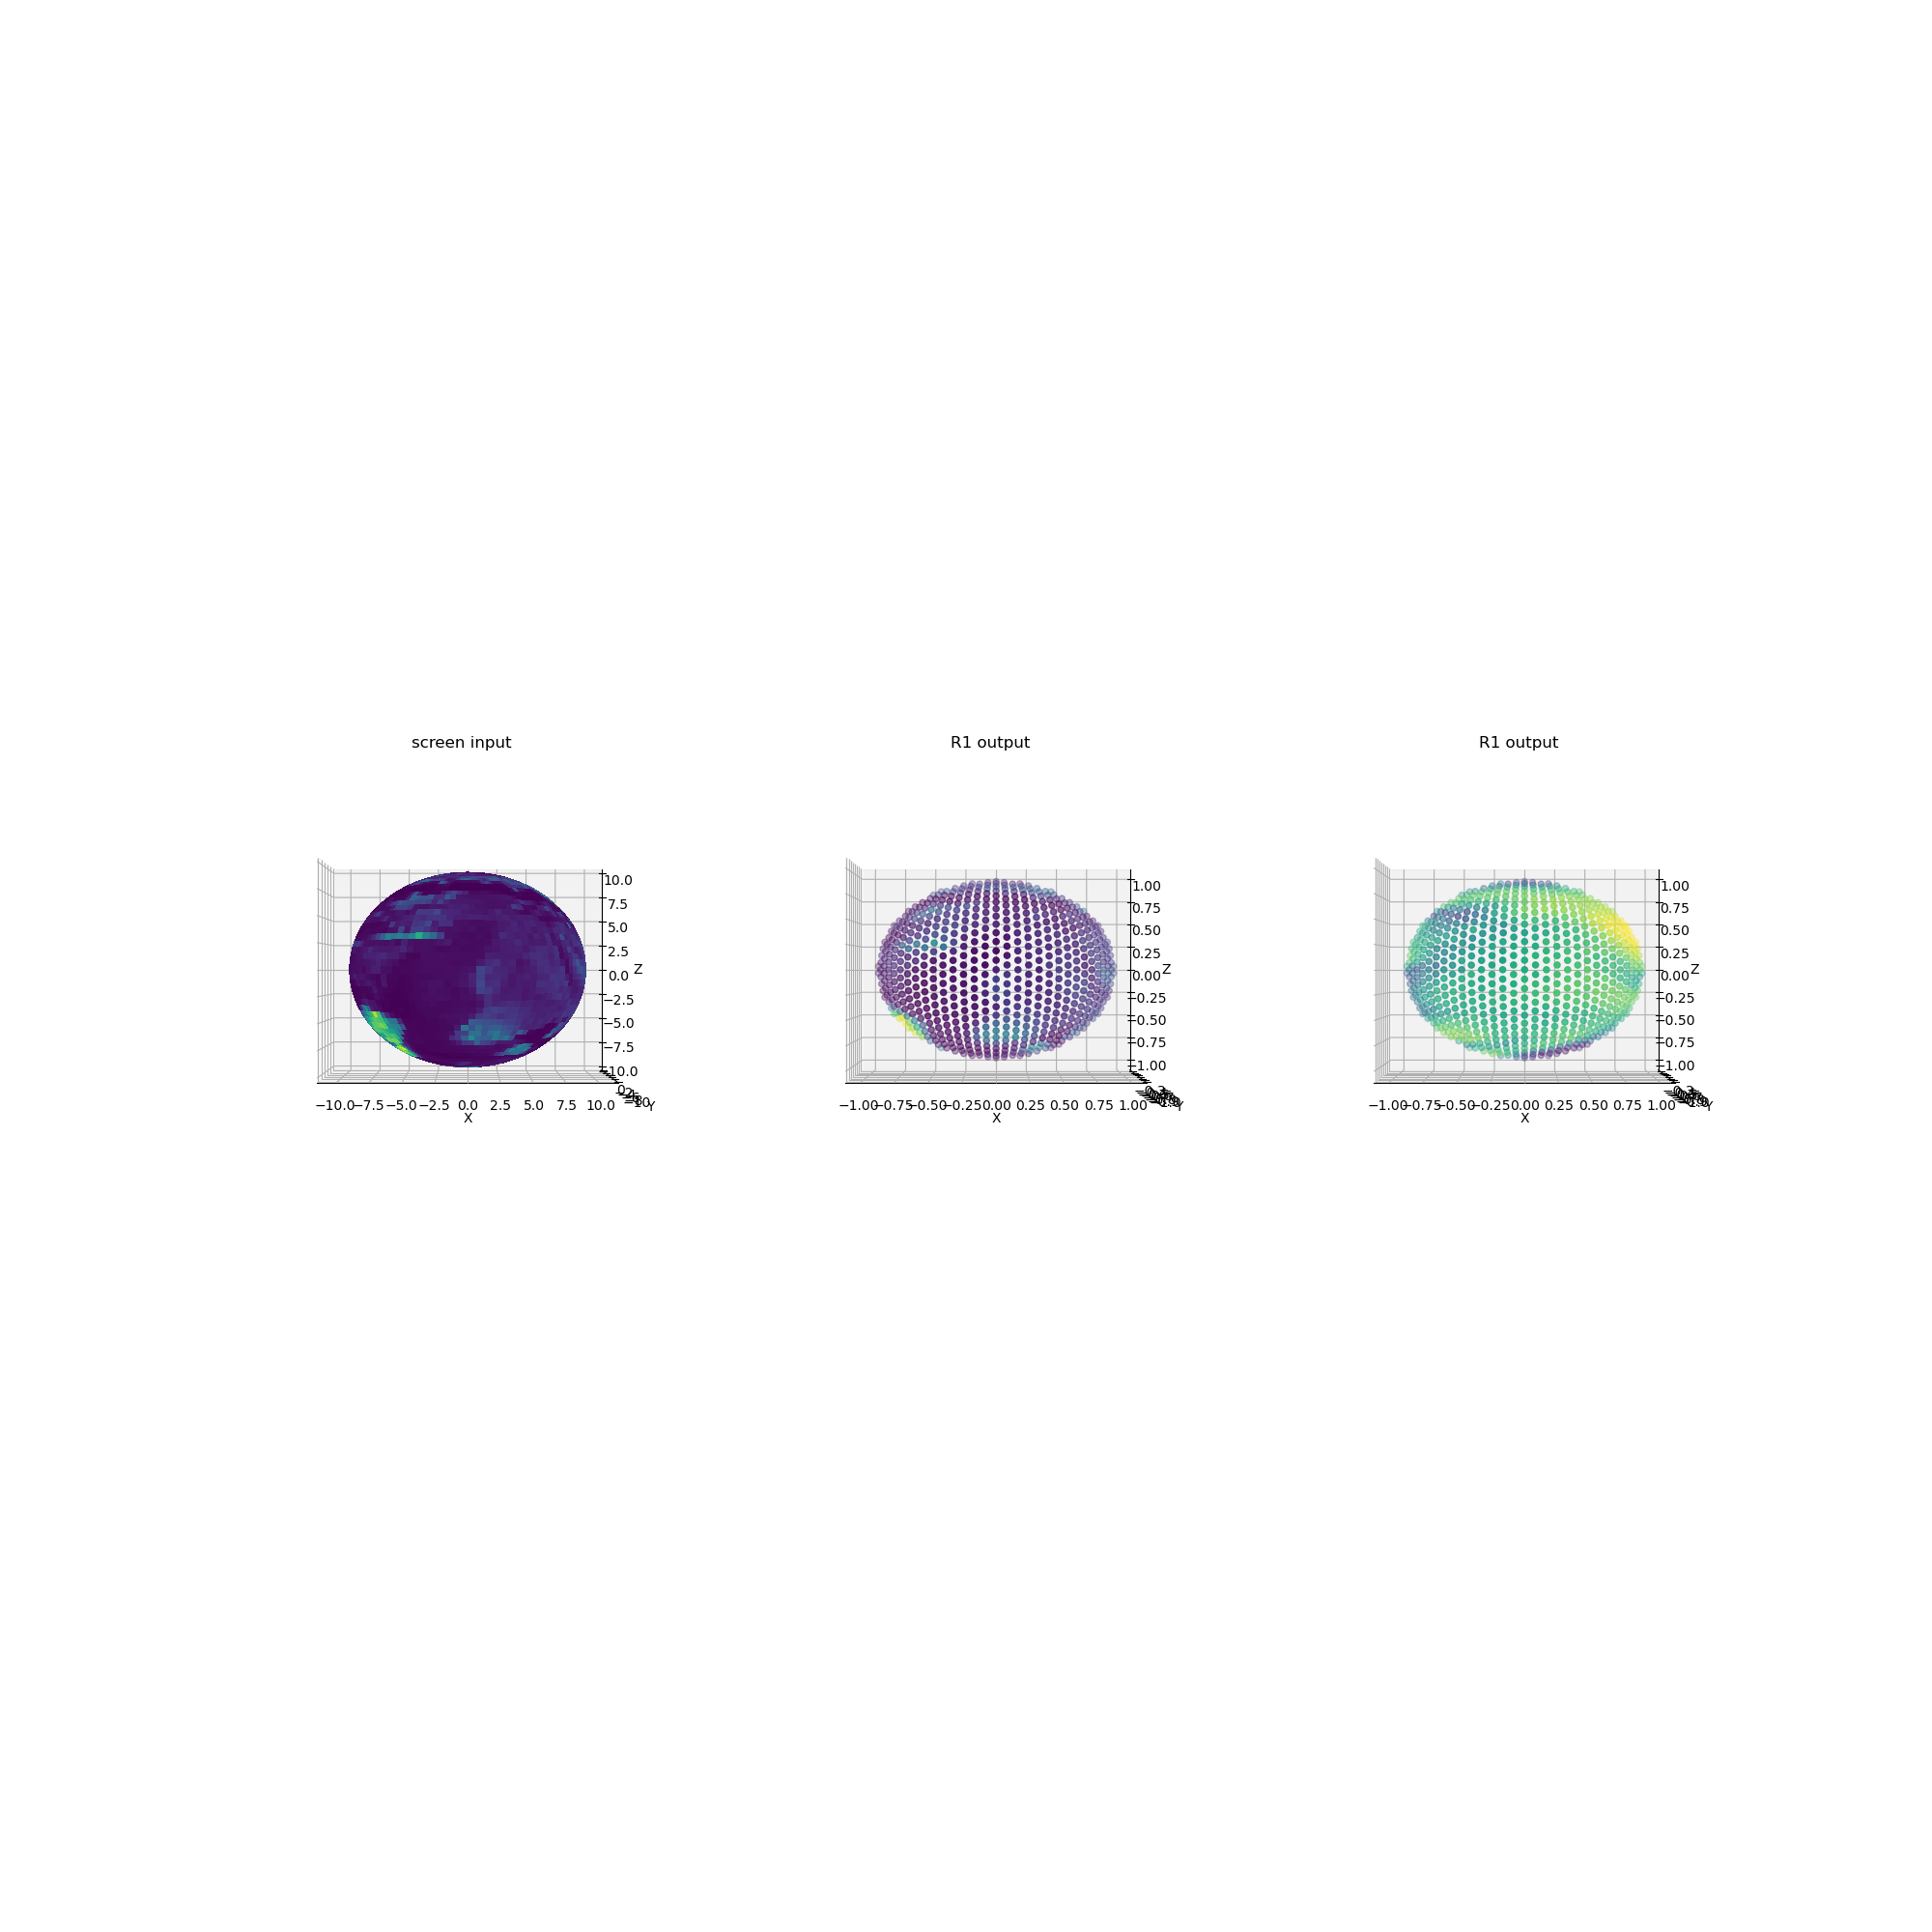

In [5]:
# here shows the screen input, R1 input, R1 output 
# a 3d view
#%matplotlib inline
frame_number = 500
frame_number_R = int(frame_number/10)
frame_number_screen = int(frame_number/10)

fig = plt.figure(figsize=(20, 20))
ax_screen_input = fig.add_subplot(1, 3, 1, projection='3d')
#ax = Axes3D(fig)
C = screen[frame_number_screen,:, :]
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
C_colored = scalarMap.to_rgba(C)
# Plot the surface.
surf = ax_screen_input.plot_surface(x2, y2, z2, facecolors= C_colored, cmap='gray',
                       linewidth=0, antialiased=False)
#ax_screen_input.scatter3D(x2, y2, z2, c= C_colored)
ax_screen_input.set_xlabel('X')
ax_screen_input.set_ylabel('Y')
ax_screen_input.set_zlabel('Z')
ax_screen_input.set_title('screen input')
ax_screen_input.view_init(azim=-90,  elev=0)

ax_R1_input = fig.add_subplot(1, 3, 2, projection='3d')
#print(np.shape(R1_inputs[90, :]))
ax_R1_input.scatter3D(x1, y1,z1, c=R1_inputs[frame_number_R, :])
#ax_R1_input.plot_surface(x1, y1,z1, facecolors=R1_inputs[frame_number_R, :])
ax_R1_input.set_xlabel('X')
ax_R1_input.set_ylabel('Y')
ax_R1_input.set_zlabel('Z')
ax_R1_input.set_title('R1 output')
ax_R1_input.view_init(azim=-90,  elev=0)

ax_R1_output = fig.add_subplot(1, 3, 3, projection='3d')
#print(np.shape(R1_inputs[90, :]))
ax_R1_output.scatter3D(x1, y1,z1, c=R1_outputs[frame_number_R, :])
ax_R1_output.set_xlabel('X')
ax_R1_output.set_ylabel('Y')
ax_R1_output.set_zlabel('Z')
ax_R1_output.set_title('R1 output')
ax_R1_output.view_init(azim=-90,  elev=0)


plt.show()

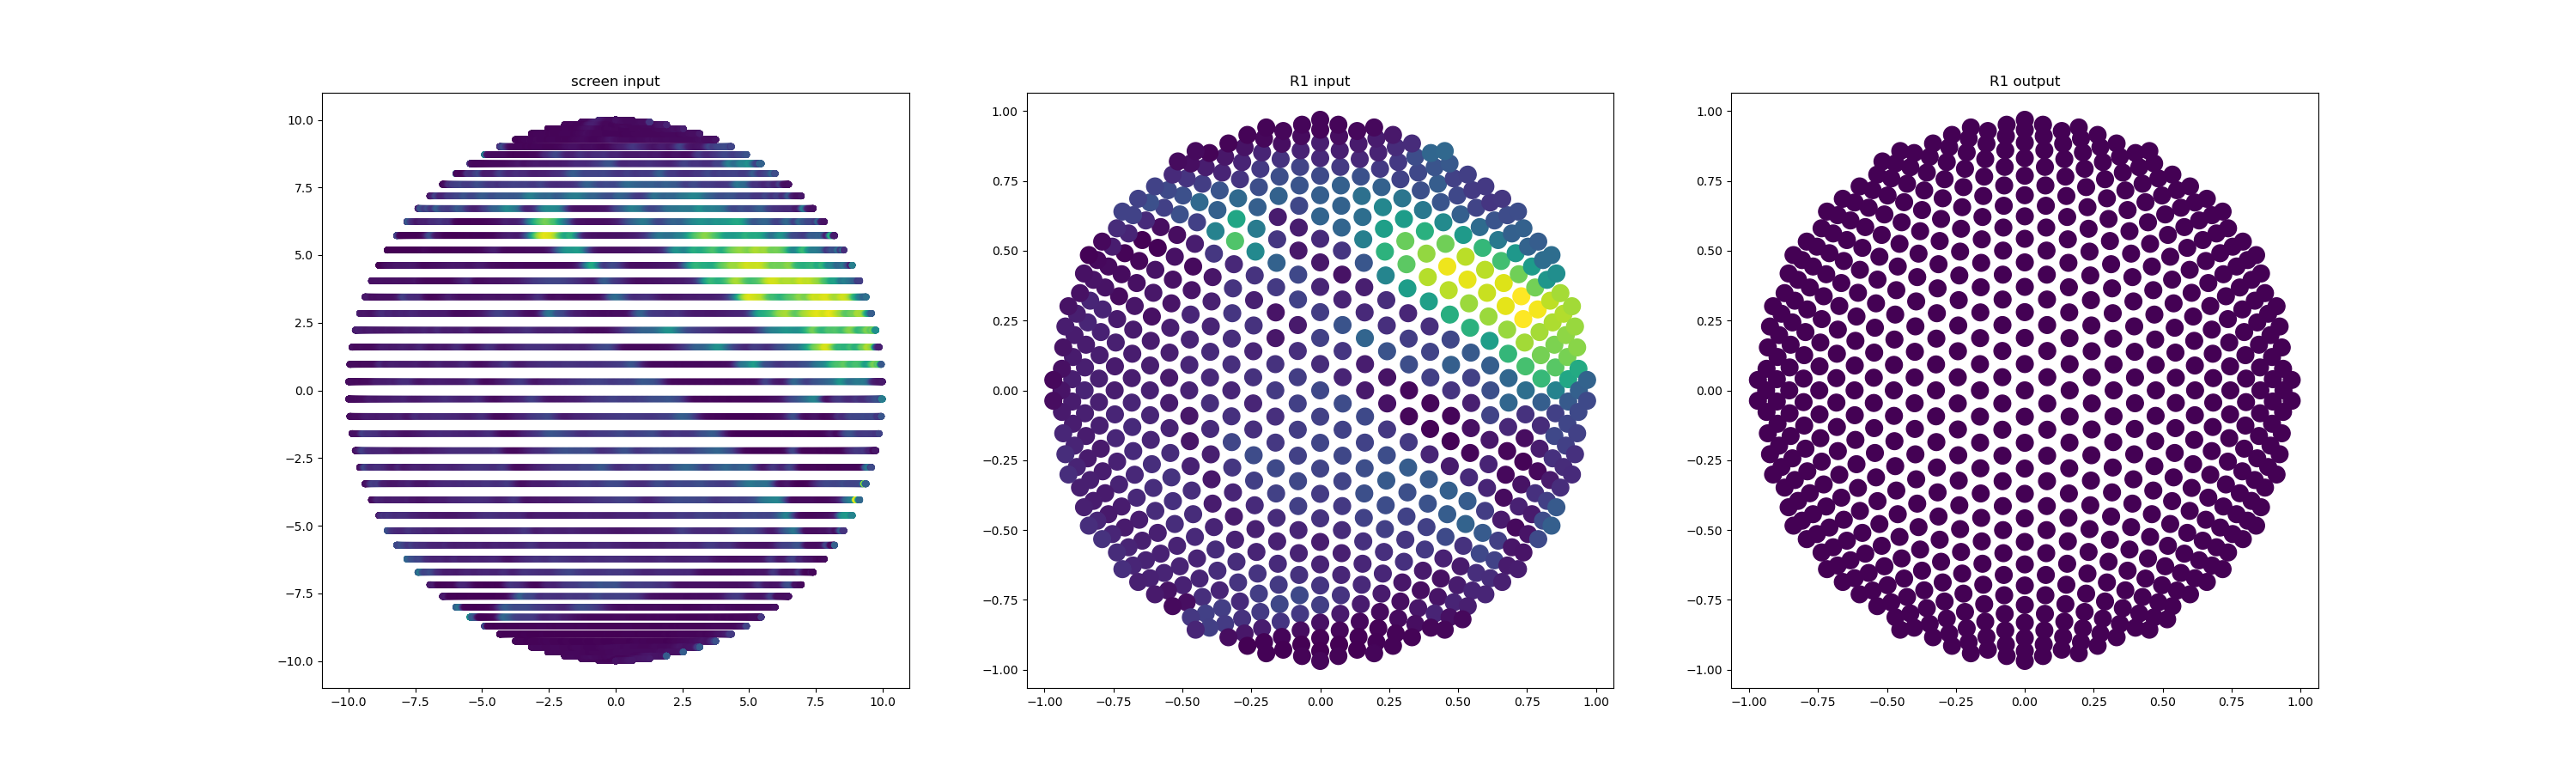

now is 0th frame
now is 0th frame
now is 50th frame


In [6]:
# same thing, but here is a top down view 
def update_plot(frame_number, screen, R1_inputs, R1_outputs, plot):
    if frame_number%50 == 0:
        print(f'now is {frame_number}th frame')
        
    plot[0].remove()
    plot[1].remove()
    plot[2].remove()
    #C = screen[frame_number,:, :]
    #scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
    #C_colored = scalarMap.to_rgba(C)
    plot[0] = ax_screen_input.scatter(x2_reshape,z2_reshape, c=screen[frame_number, :, :].reshape(-1, 1), s=20 )
    plot[1] = ax_R1_input.scatter(x1,z1, c=R1_inputs[frame_number, :], s=200)
    plot[2] = ax_R1_output.scatter(x1,z1, c=R1_outputs[frame_number, :], s=200)
    


x2_reshape = x2.reshape(-1, 1)
z2_reshape = z2.reshape(-1, 1)
    
fig = plt.figure(figsize=(30, 9))
ax_screen_input = fig.add_subplot(1, 3, 1)
'''
C = screen[0,:, :]
scalarMap = cm.ScalarMappable(norm=Normalize(vmin=C.min(), vmax=C.max()))
C_colored = scalarMap.to_rgba(C)
'''
ax_R1_input = fig.add_subplot(1, 3, 2 )
ax_R1_output = fig.add_subplot(1, 3, 3)



plot = [ax_screen_input.scatter(x2_reshape,z2_reshape, c=screen[0, :, :].reshape(-1, 1), s=20 ),
       ax_R1_input.scatter(x1,z1, c=R1_inputs[0, :], s=200),
       ax_R1_output.scatter(x1, z1, c=R1_outputs[0, :], s=200)]
#plot = [ax_R1_input.scatter(x1,z1, c=R1_inputs[0, :], s=100),
#       ax_R1_output.scatter(x1,z1, c=R1_outputs[0, :], s=100)]

ax_screen_input.set_title('screen input')
ax_R1_input.set_title('R1 input')
ax_R1_output.set_title('R1 output')


fps = 10
frn = np.shape(R1_inputs)[0]
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(screen,R1_inputs, R1_outputs, plot), interval=1000/fps)

plt.show()
Writer = animation.writers['ffmpeg']
ani.save('R1_IO_2d.mp4', writer=Writer(fps=10))
#ani.save('dear_all.gif', writer=PillowWriter(fps=10)) # have no idea why saving gif is so sloooow

In [ ]:
# transform the hemisphere to the so called hexagon
#emmm hey, I think we should first do Albers projection to the 2d plane
#but first thing first, transform the cartisian coordinate to sphere coordinate
def cartisian_to_sphere(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arctan2(y,x)
    phi = np.arccos(z)
    return r, theta, phi

#r, theta, phi = cartisian_to_sphere(x1, y1,z1)
r, theta, phi = cartisian_to_sphere(x1, z1,-y1)
print(f'theta range is {np.max(theta)} ~ { np.min(theta)}')
print(f'phi range is {np.max(phi)} ~ {np.min(phi)}')

frame_number = 50
X = r * np.sin(phi) * np.cos(theta)
Y = r * np.sin(phi) * np.sin(theta)
Z = r * np.cos(phi)
fig = plt.figure()
ax = fig.add_subplot(1,1, 1, projection = '3d')
plot = ax.scatter(X, Y, Z, c=R1_outputs[frame_number, :])
#print(np.sin(phi))
#plot = ax.scatter(x1, y1, z1)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


def albers(theta, phi):
    
    x = np.sign(np.cos(theta)) * np.sqrt((1-np.cos(phi))/(1 + np.tan(theta)**2))
    y =  x * np.tan(theta)
    return x, y

x_hexa, y_hexa = albers(theta, phi)


fig = plt.figure(figsize=(8, 3.5))
ax_R1_square = fig.add_subplot(1, 2, 2)
ax_R1_output = fig.add_subplot(1, 2, 1)

cut_num = 30
ax_R1_square.scatter(x_hexa, y_hexa, c=R1_outputs[frame_number, :], s=10)
ax_R1_output.scatter(x1,z1, c=R1_outputs[frame_number, :], s=10 )
plt.show()


In [ ]:
# Drop off the padded photoreceptor
cut_num = 64
#cut_num = 215
#cut_num = 50
x_hexa, y_hexa = albers(theta, phi)


fig = plt.figure(figsize=(6.5, 3))
ax_R1_hexa_cut = fig.add_subplot(1, 2, 2)
ax_R1_hexa = fig.add_subplot(1, 2, 1)


ax_R1_hexa.scatter(x_hexa, y_hexa, c=R1_outputs[frame_number, :], s=10)
ax_R1_hexa_cut.scatter(x_hexa[:-cut_num], y_hexa[:-cut_num], c=R1_outputs[frame_number, :-cut_num], s=10)
plt.show()

# let's see the range of hexagon
print((np.max(x_hexa[:-cut_num]) - np.min(x_hexa[:-cut_num]))/2)
print((np.max(y_hexa[:-cut_num]) - np.min(y_hexa[:-cut_num]))/2)